In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget
import seaborn as sns

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.utils import to_categorical

In [65]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import Input
from keras.optimizers.legacy import Adam
from keras.layers import Dropout
from keras.regularizers import l1,l2
from keras.layers import GRU
from keras import backend as K 
from keras import callbacks

import tensorflow as tf

# IO utils


# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [66]:
# palm_file = './temp/2024-03-04_08-17-49.emg8'
palm_file = 'new/temp/2024-03-04_11-11-02.emg8'
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='warn')
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
gestures.sort_index(inplace=True)
gestures.reset_index(drop=True, inplace=True)

print(gestures.shape)
gestures.head()

(2545, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,134045.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,...,2974.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.02
1,134078.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2933.0,2931.0,...,2975.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.05
2,134111.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,...,2975.0,2975.0,2975.0,2974.0,2978.0,2969.0,1,Neutral,0,5.08
3,134144.0,33.0,2931.0,2943.0,2932.0,2920.0,2933.0,2935.0,2934.0,2932.0,...,2974.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.12
4,134177.0,33.0,2931.0,2943.0,2932.0,2920.0,2934.0,2934.0,2934.0,2931.0,...,2975.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.15


In [67]:
OMG_CH = np.arange(50).astype(str)

# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

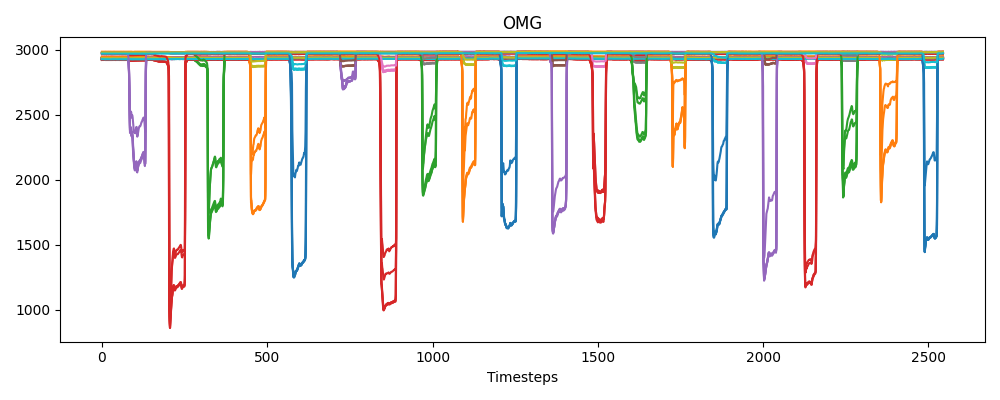

In [68]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [69]:
X = gestures[OMG_CH].values

le = LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(2545, 50) (2545,)


In [70]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

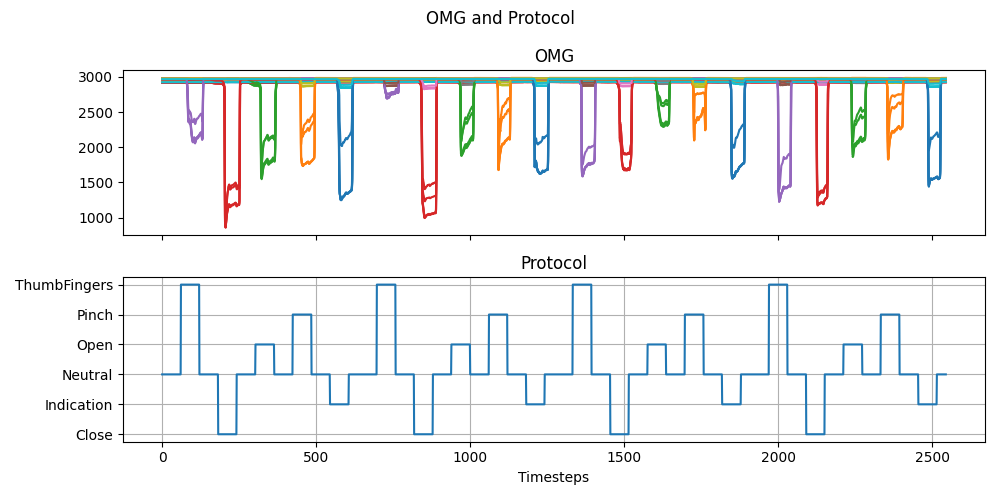

In [71]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

___
___
___

## Определение временной задержки целевой переменной.

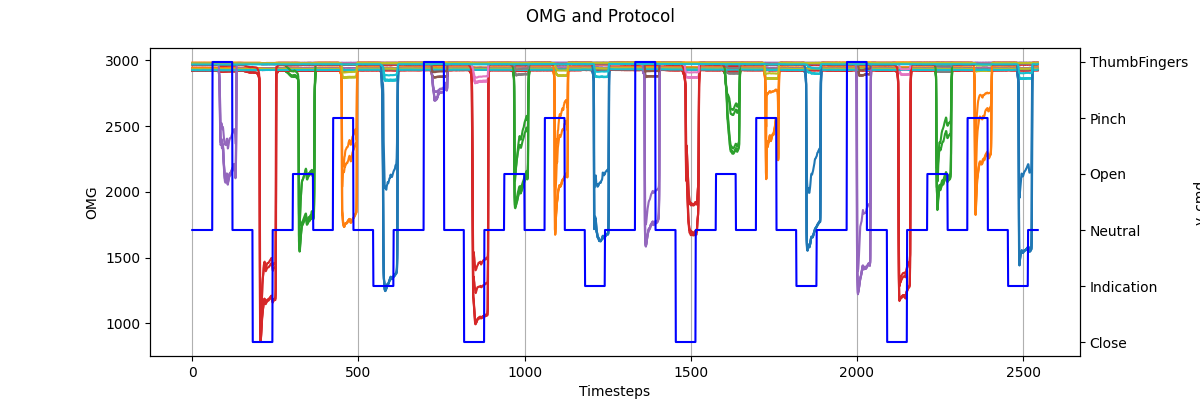

In [72]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df, 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [73]:
def add_feature_derivative(df):
  """Функция для добавления признака производной

    Args:
        df (DataFrame): датасет

    Returns:
        df_log(DataFrame): датасет с добавленным признаком производной
  """
  col_list_base = list(df.columns) #исходный список признаков
  df_temp = df.copy()
  for i in col_list_base:
    col_add = f'der_{i}' #название для нового признака
    df_temp[col_add] = df_temp[i].diff() #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем пустоты
  df_temp.drop(col_list_base, axis = 1 , inplace = True)
  return df_temp

def get_clean_lines(df, treshold = 1.5):
  """Функция для преобразования временного ряда.
  Преобразует все значения выше определенного порога в 1, ниже в 0

    Args:
        df (Series): датасет

    Returns:
        result(DataFrame): преобразованный датасет
  """
  result = np.zeros(df.shape) #создаем массив заполненный нулями размером с датасет
  means = np.mean(df) #выводим среднюю
  for i in range(df.shape[0]): #перебираем значения
    if abs(df[i]) > means*treshold:  #реализуем логику
      result[i] = 1
    else:
      result[i] = 0
  return pd.DataFrame(result)

def shift_definition(df, target):
  """Функция для нахождения временной задержки между командой и её исполнением

    Args:
        df (DataFrame): датасет с показаниями датчиков
        target (DataFrame): данные протокола выполнения команд
    Returns:
        best_shift (int): временной сдвиг
  """
  # рассчитываем производные значений временных датчиков
  gestures_der = add_feature_derivative(df)
  # суммируем модули значений производных
  gestures_der_sum = abs(gestures_der).sum(axis = 1)
  # обнуляем значения ниже порога
  gestures_der_sum_clean = get_clean_lines(gestures_der_sum, treshold = 1.5)

  # преобразуем целевую переменную в DataFrame
  target_df = pd.DataFrame(target)
  # рассчитываем производные значений таргета
  target_der = add_feature_derivative(target_df)
  # преобразуем таргет, если есть жест 1, если нет 0
  for i in range(len(target_der)):
      if (target_der.iloc[i] != 0).bool():
        target_der.iloc[i] = 1

  # объединяем преобразованный таргет и преобрразованную сумму производных в одну таблицу
  data = pd.concat([gestures_der_sum_clean.shift(1), target_der], axis=1).dropna()
  data.columns = ['y_t', 'first_derivative']
  # определяем, при каком сдвиге корреляция  максимальна
  corr_temp = []
  for i in range(1, 40):
    data['y_t'] = data['y_t'].shift(i)
    corr_coef = data.corr()
    corr_temp.append(corr_coef.iloc[1,0])
  l = pd.Series(corr_temp)
  best_shift = l[l == max(corr_temp)]
  return best_shift.index[0]

In [74]:
best_shift = shift_definition(gestures[OMG_CH], y_cmd)
print(best_shift)

35


/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_15659/3135940893.py:60: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (target_der.iloc[i] != 0).bool():


In [75]:
# сдвигаем значения таргета
target_df = pd.DataFrame(y_cmd)
target_df = target_df.shift(best_shift).fillna(0)
y_cmd_shift = target_df.values
y_cmd_shift = np.ravel(y_cmd_shift.astype(int))
y_cmd_shift

array([0, 0, 0, ..., 1, 1, 1])

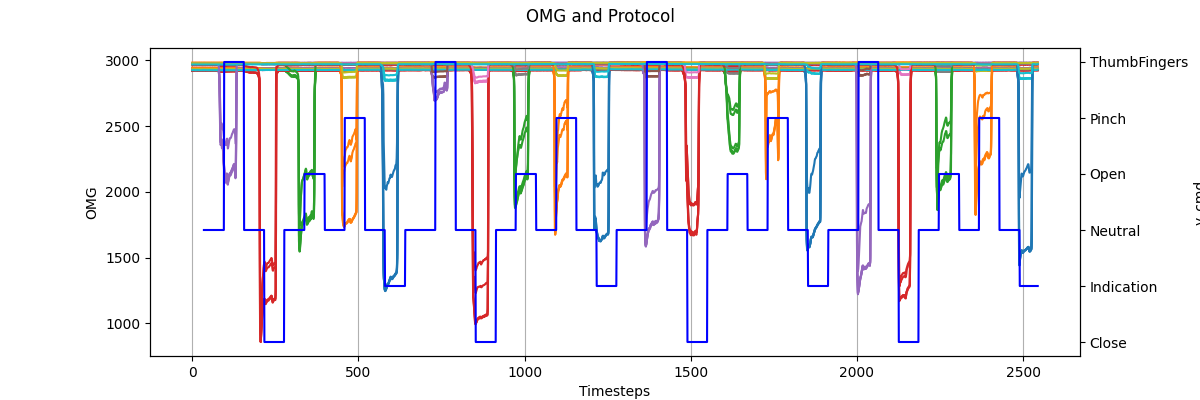

In [76]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df.shift(best_shift), 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

## Предобработка данных

## Добавление признака с экспоненциально взвешенными скользящими средними

In [77]:
def add_ewm_feature(df, span=10):
    """
    Функция для добавления столбцов с экспоненциально взвешенными скользящими
    средними (ewm) для каждого признака в DataFrame.

    Args:
        df (DataFrame): Исходный DataFrame
        span (int): Параметр span для расчета ewm (по умолчанию 10)
    Returns:
        DataFrame: DataFrame с добавленными столбцами 'ewm' для каждого признака
    """
    df_temp = df.copy()
    df_col = list(df_temp.columns)
    for col in df_col:
        col_add = f'{col}_ewm' #название для нового признака
        df_temp[col_add] = df_temp[col].ewm(span=span, adjust=False).mean()
    df_temp.drop(df_col, axis = 1, inplace = True)

    return df_temp

## Добавление суммы изменений признака за последние несколько временных шагов.

In [78]:
def add_weight_sum(df, size = 5, win_type = 'triang'):
  """Функция для добавления признака скользящей суммы, c весами значений

    Args:
        df (DataFrame): выборка
        df_col(str): список признаков из общей выборки для обработки
        size(int): размер окна
        metod(str): веса. Действительная оконная функция scipy.signal

    Returns:
        df_log(DataFrame): датасет с добавленным признаком скользящей суммы, c весами значений
  """
  df_temp = df.copy()
  df_col = list(df_temp.columns)
  for i in df_col:
    col_add = f'add_{size}_{i}' #название для нового признака
    df_temp[col_add] = round(df_temp[i].rolling(window = size, win_type = win_type).sum()) #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем нули
  df_temp.drop(df_col, axis = 1, inplace = True)

  return df_temp

## Добавление лагов

In [79]:
def add_lag(df, step = 3, lag_n = 7):
  """Функция для добавления временных лагов в выборку с шагом

    Args:
        df (DataFrame): выборка
        lag_n(int): количество временных лагов
        step(int): шаг сдвига по признакам

    Returns:
        df_temp(DataFrame): датасет с добавленными временными лагами, пропуски заполнены 0
  """

  df_temp = df.copy() #coздаем новый датасет для добавления новых признаков
  df_col = list(df_temp.columns) #исходный список признаков
  col_step = [] #список признаков с шагом
  for i in range(0, len(df_col), step): #перебираем признаки
    col_step.append(df_col[i]) #формируем список признаков с шагом
  for _, col in enumerate(col_step): #перебираем список признаков с шагом
    for n, v in enumerate(range(1,lag_n)): #перебираем лаги
      col_lag = f'{col}_lag_{v}' #название для нового признака
      df_temp[col_lag] = df_temp.loc[:, col].shift(v, fill_value = 0) #создаем новый признак
  df_temp.drop(df_col, axis = 1, inplace = True)

  return df_temp

In [80]:
data_n = gestures[OMG_CH]
# Добавление признака с экспоненциально взвешенными скользящими средними
data_add_ewm = add_ewm_feature(data_n)
# Добавление суммы изменений признака за последние несколько временных шагов.
data_weight_sum = add_weight_sum(data_n, size = 5, win_type = 'triang')
# Добавление лагов
data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
# объединение преобразований
df = pd.concat([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)

In [81]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40_lag_1,40_lag_2,42_lag_1,42_lag_2,44_lag_1,44_lag_2,46_lag_1,46_lag_2,48_lag_1,48_lag_2
0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,2936.0,2927.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2933.0,2931.0,2936.0,2927.0,...,2973.0,0.0,2974.0,0.0,2974.0,0.0,2975.0,0.0,2978.0,0.0
2,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,2935.0,2927.0,...,2973.0,2973.0,2974.0,2974.0,2975.0,2974.0,2975.0,2975.0,2978.0,2978.0
3,2931.0,2943.0,2932.0,2920.0,2933.0,2935.0,2934.0,2932.0,2936.0,2927.0,...,2973.0,2973.0,2974.0,2974.0,2975.0,2975.0,2975.0,2975.0,2978.0,2978.0
4,2931.0,2943.0,2932.0,2920.0,2934.0,2934.0,2934.0,2931.0,2936.0,2927.0,...,2973.0,2973.0,2974.0,2974.0,2974.0,2975.0,2975.0,2975.0,2978.0,2978.0


# Train-test split

In [82]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [83]:
num_classes = len(set(y_cmd_shift))
num_samples = len(y_cmd_shift)
one_hot_target = np.zeros((num_samples, num_classes))

# Subtract 1 from target labels
adjusted_target = y_cmd_shift - 1

one_hot_target[np.arange(num_samples), adjusted_target] = 1

In [84]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled)

In [85]:
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.264985,0.256267,0.256040,0.258284,0.196883,0.018253,0.047916,-0.168662,0.068161,0.085243,...,-8.015489,-7.913126,-11.605218,-11.305543,-10.295918,-10.084104,-48.647544,-35.007788,-48.909568,-35.105133
1,0.264985,0.256267,0.256040,0.258284,0.196883,0.018253,-0.017541,-0.168662,0.068161,0.085243,...,0.269396,-7.913126,0.258556,-11.305543,0.212008,-10.084104,0.039290,-35.007788,0.044193,-35.105133
2,0.264985,0.256267,0.256040,0.258284,0.196883,0.018253,0.047916,-0.168662,0.000054,0.085243,...,0.269396,0.269279,0.258556,0.256528,0.215542,0.211788,0.039290,0.042071,0.044193,0.045558
3,0.264985,0.256267,0.256040,0.255519,0.196883,0.101802,0.047916,-0.025580,0.068161,0.085243,...,0.269396,0.269279,0.258556,0.256528,0.215542,0.215250,0.039290,0.042071,0.044193,0.045558
4,0.264985,0.256267,0.256040,0.255519,0.201759,0.018253,0.047916,-0.168662,0.068161,0.085243,...,0.269396,0.269279,0.258556,0.256528,0.212008,0.215250,0.039290,0.042071,0.044193,0.045558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,0.267893,0.269800,0.273314,0.266578,0.245640,0.268900,0.244287,0.260583,0.204376,0.151871,...,0.266610,0.266527,0.270523,0.268191,0.243808,0.242946,0.072020,0.077415,0.077070,0.057362
2541,0.267893,0.269800,0.273314,0.269343,0.240765,0.268900,0.244287,0.260583,0.204376,0.151871,...,0.266610,0.266527,0.270523,0.268191,0.247341,0.242946,0.088386,0.065634,0.077070,0.069165
2542,0.270801,0.269800,0.273314,0.269343,0.245640,0.268900,0.244287,0.260583,0.272484,0.285128,...,0.269396,0.266527,0.270523,0.268191,0.247341,0.246408,0.088386,0.077415,0.077070,0.069165
2543,0.270801,0.269800,0.273314,0.269343,0.245640,0.352450,0.244287,0.260583,0.272484,0.285128,...,0.269396,0.269279,0.270523,0.268191,0.243808,0.246408,0.088386,0.077415,0.077070,0.069165


In [86]:
def add_lag_3d(df, lag=40):
    columns = [df.shift(i) for i in range(lag)]
    df_concat = pd.concat(columns, axis=1)
    df_concat = df_concat.fillna(0)
    df_values = df_concat.values
    
    return df_values.reshape(df_values.shape[0], lag, df.shape[1])

df_3d = add_lag_3d(df, lag=20)

In [87]:
df_3d.shape

(2545, 20, 200)

In [88]:
X_train = df_3d[:int(df_3d.shape[0] * 0.8)+1]
y_train_encode = one_hot_target[:int(df_3d.shape[0] * 0.8)+1]

X_test = df_3d[int(df_3d.shape[0] * 0.8)+1:]
y_test_encode = one_hot_target[int(df_3d.shape[0] * 0.8)+1:]

print(X_train.shape, y_train_encode.shape)
print(X_test.shape, y_test_encode.shape)

(2037, 20, 200) (2037, 6)
(508, 20, 200) (508, 6)


# Modeling

___
___
___

In [89]:
def plot_accur(history, epochs=20):
    acc = history.history['f1_score']
    val_acc = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Mean F-score')
    plt.plot(epochs_range, val_acc, label='Validation Mean F-score')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Mean F-score')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [90]:
def f1_score(y_true, y_pred):
    # Function to calculate F-score
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [91]:
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = y_train_encode.shape[1]

GRU

In [257]:
X_train.shape[0]

2037

In [92]:
model_gru = Sequential()
model_gru.add(GRU(units=32, kernel_regularizer=l2(0.1), return_sequences=True, input_shape=(n_timesteps, n_features), dropout=0.5))
model_gru.add(GRU(units=16, input_shape=(n_timesteps, n_features), dropout=0.5))
model_gru.add((Dense(n_classes, activation='softmax')))

optimizer = Adam()

model_gru.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=[f1_score])

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", patience=20,
    restore_best_weights=True
)

history_gru = model_gru.fit(X_train, 
                    y_train_encode, 
                    epochs=100, 
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=earlystopping
                    )

K.clear_session()

Epoch 1/100
48/48 [==============================] - 5s 57ms/step - loss: 9.4473 - f1_score: 0.5328 - val_loss: 5.3228 - val_f1_score: 0.8501
Epoch 2/100
48/48 [==============================] - 2s 37ms/step - loss: 3.3594 - f1_score: 0.8789 - val_loss: 1.9011 - val_f1_score: 0.8732
Epoch 3/100
48/48 [==============================] - 2s 37ms/step - loss: 1.2156 - f1_score: 0.9172 - val_loss: 0.8534 - val_f1_score: 0.8861
Epoch 4/100
48/48 [==============================] - 2s 37ms/step - loss: 0.5529 - f1_score: 0.9362 - val_loss: 0.4978 - val_f1_score: 0.9016
Epoch 5/100
48/48 [==============================] - 2s 37ms/step - loss: 0.3508 - f1_score: 0.9449 - val_loss: 0.3411 - val_f1_score: 0.9204
Epoch 6/100
48/48 [==============================] - 2s 37ms/step - loss: 0.2685 - f1_score: 0.9495 - val_loss: 0.3104 - val_f1_score: 0.9283
Epoch 7/100
48/48 [==============================] - 2s 36ms/step - loss: 0.2181 - f1_score: 0.9578 - val_loss: 0.3474 - val_f1_score: 0.9264
Epoch 

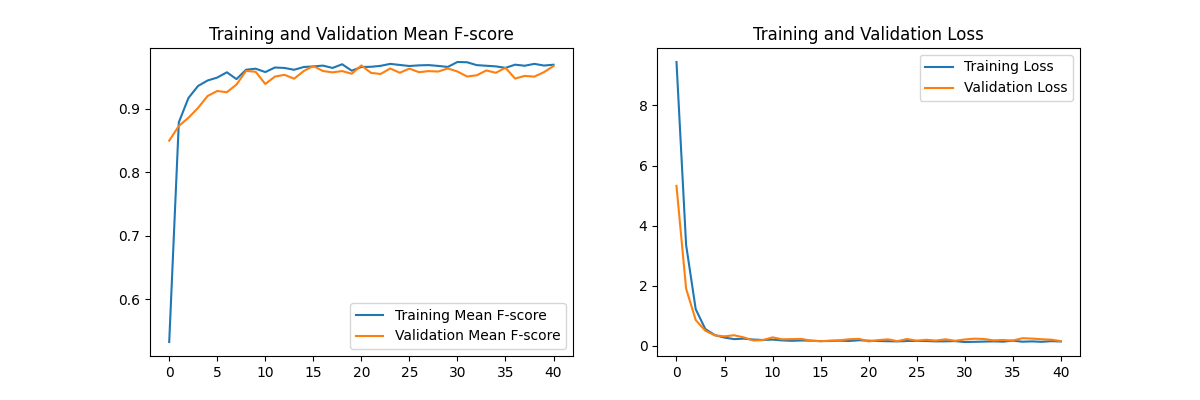

In [94]:
plot_accur(history_gru, epochs=41)

### Подбор гиперпараметров

___
___
___

## Prediction

In [95]:
y_pred_train = model_gru.predict(X_train)
y_pred_test = model_gru.predict(X_test)

16/16 [==============================] - 0s 8ms/step


In [96]:
def y_to_2d(y):
    y = np.round(y)
    indices_of_1 = np.argmax(y, axis=1)
    indices_of_1 = indices_of_1 + 1
    indices_of_1[indices_of_1 == 6] = 0
    return indices_of_1

In [97]:
y_pred_train = y_to_2d(y_pred_train)
y_pred_test = y_to_2d(y_pred_test)

y_train = y_cmd_shift[:int(df_3d.shape[0] * 0.8)+1]
y_test = y_cmd_shift[int(df_3d.shape[0] * 0.8)+1:]

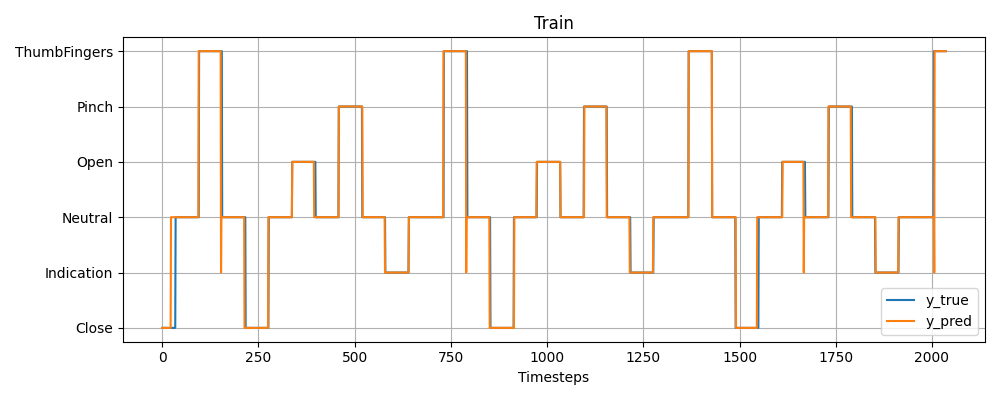

In [98]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

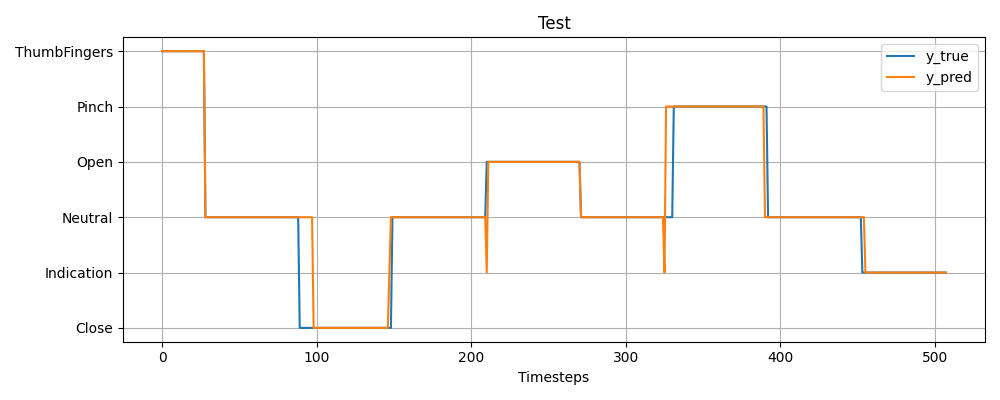

In [99]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [100]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

       Close       0.97      0.92      0.94       216
  Indication       0.96      0.98      0.97       182
     Neutral       0.96      0.99      0.98      1061
        Open       0.99      0.95      0.97       182
       Pinch       0.99      0.97      0.98       182
ThumbFingers       0.99      0.96      0.98       214

    accuracy                           0.97      2037
   macro avg       0.98      0.96      0.97      2037
weighted avg       0.97      0.97      0.97      2037

              precision    recall  f1-score   support

       Close       1.00      0.82      0.90        60
  Indication       0.95      0.96      0.95        55
     Neutral       0.94      0.98      0.96       243
        Open       1.00      0.98      0.99        61
       Pinch       0.92      0.97      0.94        61
ThumbFingers       1.00      1.00      1.00        28

    accuracy                           0.96       508
   macro avg       0.97

### pickle

In [281]:
import pickle

In [282]:
with open('model_gru.pickle', 'wb') as f:
    pickle.dump(model_gru, f)

### ONNX

In [227]:
import onnx
import tf2onnx
import onnxruntime

In [283]:
onnx_model, _ = tf2onnx.convert.from_keras(model=model_gru)
onnx.save_model(proto=onnx_model, f='model_gru.onnx')
sess = onnxruntime.InferenceSession(path_or_bytes='model_gru.onnx')
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

2024-03-15 04:01:08.611107: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-03-15 04:01:08.611539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 04:01:08.611554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-15 04:01:08.857853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 04:01:08.857878: I tensorflow/core/com

# Real-time inference

In [44]:
import time
import serial
from IPython.display import clear_output

In [45]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [287]:
def preprocessing(data, prev, n_lags = 20):
    if prev is None:
        data_n = pd.DataFrame([data])
        prev = np.vstack([np.zeros([19,200])])
        # Добавление признака с экспоненциально взвешенными скользящими средними
        data_add_ewm = add_ewm_feature(data_n)
        # Добавление суммы изменений признака за последние несколько временных шагов.
        data_weight_sum = add_weight_sum(data_n, size = 5, win_type = 'triang')
        # Добавление лагов
        data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
        # объединение преобразований
        df = np.concatenate([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)
        y = np.vstack([df, prev])
        prev = y[:-1]
        # y = y.reshape(1, n_lags, df.shape[1])
        
    else:
        data_n = pd.DataFrame([data])
        # Добавление признака с экспоненциально взвешенными скользящими средними
        data_add_ewm = add_ewm_feature(data_n)
        # Добавление суммы изменений признака за последние несколько временных шагов.
        data_weight_sum = add_weight_sum(data_n, size = 5, win_type = 'triang')
        # Добавление лагов
        data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
        # объединение преобразований
        df = np.concatenate([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)
        y = np.vstack([df, prev])
        prev = y[:-1]
        # y = y.reshape(1, n_lags, df.shape[1])
    return y, prev

def inference(x):

    y = sess.run(output_names=[output_name], input_feed={input_name: [x]})[0]
    # model_gru.predict(x)
    return y[-1]

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # 'Close'
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 1: # 'Indication'
        cmd.update({'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 2: # 'Neutral'
        pass
        return cmd
    elif x == 3: # 'Open'
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 4: # 'Pinch'
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 5: # 'ThumbFingers'
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    else:
        return cmd

In [118]:
import warnings
warnings.filterwarnings('ignore')

## Inference

### Offline (dataset)

In [161]:
df_temp = gestures.iloc[:, :52]
df_columns = df_temp.columns
df = StandardScaler().fit_transform(df_temp)
df_sim = pd.DataFrame(df, columns = df_columns)
print(df_sim.shape)

(2545, 52)


In [176]:
df_sim

,ts,td,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,-1.731370,0.0,0.264985,0.256267,0.256040,0.258284,0.196883,0.018253,0.047916,-0.168662,...,0.269562,0.260170,0.260884,0.262765,0.212335,0.090661,0.076263,-0.052970,0.102073,0.124783
1,-1.730009,0.0,0.264985,0.256267,0.256040,0.258284,0.196883,0.018253,-0.017541,-0.168662,...,0.269562,0.260170,0.260884,0.262765,0.215945,0.090661,0.076263,-0.052970,0.102073,0.124783
2,-1.728648,0.0,0.264985,0.256267,0.256040,0.258284,0.196883,0.018253,0.047916,-0.168662,...,0.269562,0.260170,0.260884,0.262765,0.215945,0.090661,0.076263,0.091985,0.102073,0.124783
3,-1.727287,0.0,0.264985,0.256267,0.256040,0.255519,0.196883,0.101802,0.047916,-0.025580,...,0.269562,0.260170,0.260884,0.262765,0.212335,0.090661,0.076263,-0.052970,0.102073,0.124783
4,-1.725926,0.0,0.264985,0.256267,0.256040,0.255519,0.201759,0.018253,0.047916,-0.168662,...,0.269562,0.260170,0.260884,0.262765,0.215945,0.090661,0.076263,-0.052970,0.102073,0.124783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,1.725926,0.0,0.267893,0.269800,0.273314,0.266578,0.245640,0.268900,0.244287,0.260583,...,0.266739,0.268862,0.273181,0.269804,0.248428,0.253150,0.262173,0.236940,0.236637,0.191040
2541,1.727287,0.0,0.267893,0.269800,0.273314,0.269343,0.240765,0.268900,0.244287,0.260583,...,0.269562,0.268862,0.273181,0.272151,0.248428,0.334394,0.262173,0.236940,0.236637,0.191040
2542,1.728648,0.0,0.270801,0.269800,0.273314,0.269343,0.245640,0.268900,0.244287,0.260583,...,0.269562,0.273208,0.273181,0.272151,0.244818,0.334394,0.262173,0.236940,0.236637,0.257298
2543,1.730009,0.0,0.270801,0.269800,0.273314,0.269343,0.245640,0.352450,0.244287,0.260583,...,0.269562,0.273208,0.273181,0.272151,0.244818,0.253150,0.262173,0.236940,0.303919,0.323555


In [288]:
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0;
ts_diff_list = []
n_lags = 20

x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    # 'y_commands':[],
}
while True:

    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])

    except Exception as e:
        print(e)

    # [Data preprocessing]
    # print(omg_sample.shape)
    sample_preprocessed, x_previous  = preprocessing(omg_sample, x_previous, n_lags)
    # a = y_dct['omg_sample'][-n_lags:]
    # print(f'IS PRINTED {a}')
    # [/Data preprocessing]
    # y_dct['sample_preprocessed'].append(sample_preprocessed)

    # [Inference]
    y_predicted        = inference(sample_preprocessed) 
    # y_dct['sample_preprocessed'][-n_lags:]
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    # y_commands          = commands(y_postprocessed.argmax())
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    x_previous = x_previous
    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        # print(y_commands)

    ts_diff = time.time() - ts_start
    ts_diff_list.append(ts_diff)
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1
print(round(np.array(ts_diff_list).max(),3))

0.483


In [289]:
y_pred_real = y_to_2d(y_dct['y_predicted'])

In [291]:
y_pred_post = y_to_2d(y_dct['y_postprocessed'])

In [292]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (2545, 50)
sample_preprocessed.shape = (2545, 20, 200)
y_predicted.shape = (2545, 6)
y_postprocessed.shape = (2545, 6)


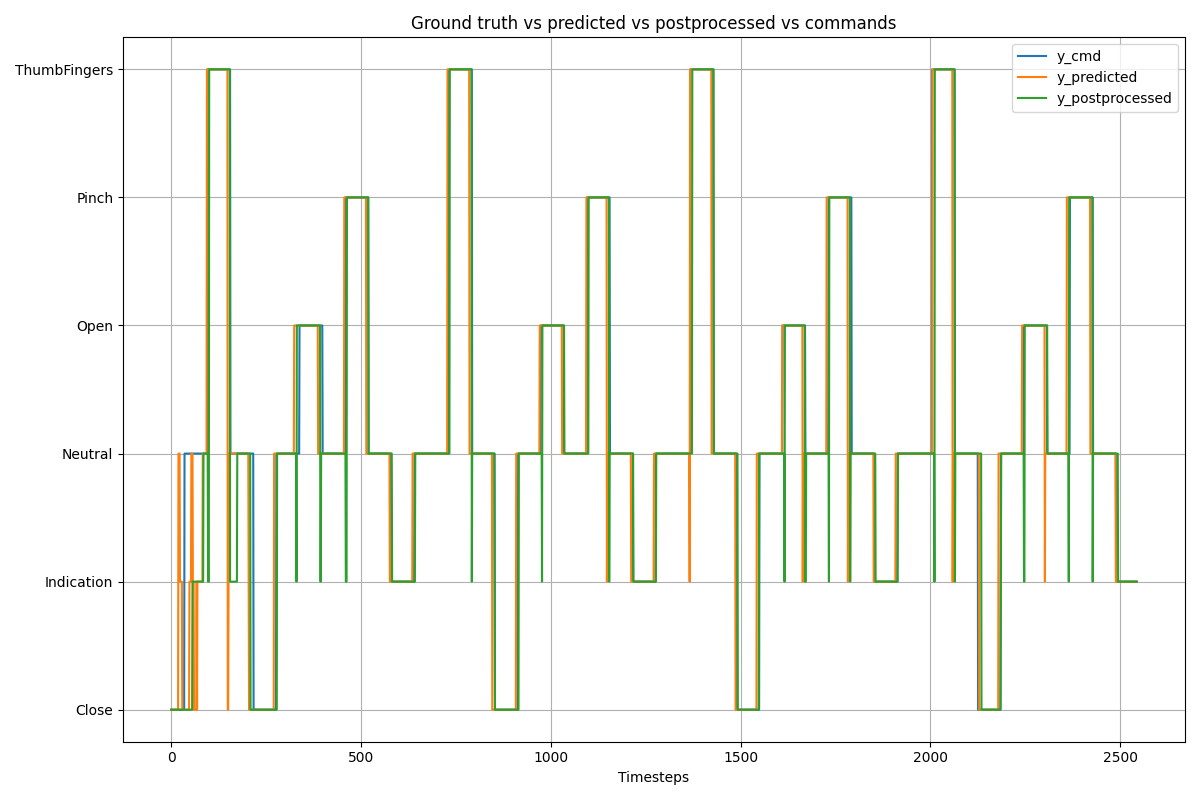

In [293]:
fig = plt.figure(figsize=(12, 8))

plt.plot(y_cmd_shift, c='C0', label='y_cmd')

# plt.plot(y_dct['y_predicted'].argmax(axis=1), c='C1', label='y_predicted')
# plt.plot(y_dct['y_postprocessed'].argmax(axis=1), c='C2', label='y_postprocessed')

plt.plot(y_pred_real, c='C1', label='y_predicted')
plt.plot(y_pred_post, c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [201]:
y_test.shape

(508,)

In [294]:
print(classification_report(y_cmd_shift, y_pred_real, target_names=GESTURES))

              precision    recall  f1-score   support

       Close       0.84      0.87      0.85       276
  Indication       0.82      0.94      0.87       237
     Neutral       0.90      0.90      0.90      1304
        Open       0.90      0.88      0.89       243
       Pinch       0.92      0.87      0.90       243
ThumbFingers       0.97      0.89      0.93       242

    accuracy                           0.90      2545
   macro avg       0.89      0.89      0.89      2545
weighted avg       0.90      0.90      0.90      2545



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 